Set up the environment

In [48]:
import x_xy
from x_xy.subpkgs import pipeline
import jax
import jax.numpy as jnp
import jax.random as random

import neural_networks
from neural_networks.rnno import rnno_v2, SaveParamsTrainingLoopCallback, train
from neural_networks import io_params

# Defining the System
A system is defined in an XML structure. To read a system, an XML file may be used.<br>It is also possible to define the system inline by using a string in XML-syntax.

In [2]:
three_seg_rigid = r"""
<x_xy model="three_seg_rigid">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg2" joint="free">
            <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05" vispy_color="red"/>
            <body name="seg1" joint="rsry" pos="0 0 0">
                <geom type="box" mass="10" pos="-0.1 0 0" dim="-0.2 0.05 0.05" vispy_color="yellow"/>
                <body name="imu1" pos="-0.1 0.0 0.03" joint="frozen">
                    <geom type="box" mass="2" pos="0 0 0" dim="0.05 0.01 0.01" vispy_color="lightgreen"/>
                </body>
            </body>
            <body name="seg3" joint="rsrz" pos="0.2 0 0">
                <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05" vispy_color="blue"/>
                <body name="imu2" joint="frozen" pos="0.1 0.0 0.03">
                    <geom type="box" mass="2" pos="0 0 0" dim="0.05 0.01 0.01" vispy_color="lightgreen"/>
                </body>
            </body>
        </body>
    </worldbody>
    <defaults>
        <geom vispy_edge_color="black" vispy_color="1 0.8 0.7 1"/>
    </defaults>
</x_xy>
"""

In [3]:
dustin_exp_xml_seg1 = r"""
<x_xy model="dustin_exp">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg1" joint="free">
            <body name="seg2" joint="ry">
                <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05"/> 
                <body name="seg3" joint="rx"></body>
                    <geom type="box" mass="10" pos="0.3 0 0" dim="0.2 0.05 0.05"/>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

# Registering the joint axis
For this scenario, we define two systems: One for generating data with rigid phases and one for inference.<br>
To generate the random data with rigid phases, we first have to register a joint type, that allows for the creation of such data.<br>
We call this joint 'rsr\<x|y|z\>', a hinge joint that produces **r**andom **s**ometimes **r**igid data, and turns around the respective axis $x$, $y$ or $z$ in its frame.

## Generating random data
The random data is generated by the following functions:

In [8]:
# Helper function - Creates a discrete array of values x <- [0, 1] which may be multiplied to another sequence.
def motion_amplifier(
        time : float,
        sampling_rate : float,
        key_rigid_phases : random.KeyArray,
        n_rigid_phases=3,
        rigid_duration_cov=jnp.array([0.02] * 3),
        transition_cov=jnp.array([0.1] * 3)
) -> jax.Array:
    error_msg = "motion_amplifier: There must be a variance for each rigid phase!"
    assert rigid_duration_cov.shape == (n_rigid_phases,) == transition_cov.shape, error_msg
    n_frames = int(time / sampling_rate)
    key_rigid_means, key_rigid_variances, key_slope_down_variances, key_slope_up_variances = random.split(key_rigid_phases, 4)

    # Calculate center points of rigid phases
    means = jnp.sort(random.uniform(key_rigid_means, shape=(n_rigid_phases, 1), minval=0, maxval=n_frames).T)

    # Calculate durations, which is twice the rigid distance from the center points for each rigid phase.
    rigid_distances = jnp.abs(random.multivariate_normal(
        key_rigid_variances, mean=jnp.zeros_like(means), cov=jnp.diag((rigid_duration_cov * n_frames)**2)))

    # Calculate transition durations
    transition_slowdown_durations = jnp.abs(random.multivariate_normal(
        key_slope_down_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))
    transition_speedup_durations = jnp.abs(random.multivariate_normal(
        key_slope_up_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))

    # Phase start and end points
    rigid_starts = (means - rigid_distances).astype(int).flatten()
    rigid_ends = (means + rigid_distances).astype(int).flatten()
    starts_slowing = (means - rigid_distances -
                      transition_slowdown_durations).astype(int).flatten()
    ends_moving = (means + rigid_distances +
                   transition_speedup_durations).astype(int).flatten()

    # Create masks
    def create_mask(start, end):
        nonlocal n_frames
        return jnp.where(jnp.arange(n_frames) < start, 1, 0) + jnp.where(jnp.arange(n_frames) >= end, 1, 0)

    mask = jax.vmap(create_mask)
    rigid_mask = jnp.prod(mask(rigid_starts, rigid_ends), axis=0)
    slowdown_masks = mask(starts_slowing, rigid_starts).astype(float)
    speedup_masks = mask(rigid_ends, ends_moving).astype(float)

    def linsp(mask, start, end, begin_val, carry_fun):
        range = end - start
        def true_fun(carry, x): return (carry_fun(carry, range), 1 - carry)
        def false_fun(carry, x): return (carry, x)
        def f(carry, x): return jax.lax.cond(
            x == 0, true_fun, false_fun, *(carry, x))
        return jax.lax.scan(f, begin_val, mask)[1]

    linsp_desc = jax.vmap(lambda m, s1, s2: linsp(
        m, s1, s2, 0.0, lambda carry, range: carry + 1/range))
    slowdown_mask = jnp.prod(linsp_desc(
        slowdown_masks, starts_slowing, rigid_starts), axis=0)

    linsp_asc = jax.vmap(lambda m, s1, s2: linsp(
        m, s1, s2, 1.0, lambda carry, range: carry - 1/range))
    speedup_mask = jnp.prod(
        linsp_asc(speedup_masks, rigid_ends, ends_moving), axis=0)

    return jnp.min(jnp.stack([rigid_mask, slowdown_mask, speedup_mask]), axis=0)

In [9]:
# Random generator: Uses the motion_amplifier to amplify the angles, generated by another function.
def random_angles_with_rigid_phases_over_time(
    key_t,
    key_ang,
    key_rigid_phases,
    n_rigid_phases=3,
    rigid_duration_cov=jnp.array([0.02] * 3),
    transition_cov=jnp.array([0.1] * 3),
    config: x_xy.algorithms.RCMG_Config=x_xy.algorithms.RCMG_Config()
):

    mask = motion_amplifier(config.T, config.Ts, key_rigid_phases,
                            n_rigid_phases, rigid_duration_cov, transition_cov)
    
    qs = x_xy.algorithms.random_angle_over_time(
        key_t=key_t,
        key_ang=key_ang,
        ANG_0=config.ang0_max,
        dang_min=config.dang_min,
        dang_max=config.dang_max,
        delta_ang_min=config.delta_ang_min,
        delta_ang_max=config.delta_ang_max,
        t_min=config.t_min,
        t_max=config.t_max,
        T=config.T,
        Ts=config.Ts,
        randomized_interpolation=config.randomized_interpolation_angle,
        range_of_motion=config.range_of_motion_hinge,
        range_of_motion_method=config.range_of_motion_hinge_method
    )

    # derivate qs
    qs_diff = jnp.diff(qs, axis=0)

    # mulitply with motion amplifier
    qs_diff = qs_diff * mask[:-1]

    # integrate qs_diff
    qs_rigid_phases = jnp.concatenate((qs[0:1], jnp.cumsum(qs_diff, axis=0)))
    return qs_rigid_phases

## Defining the random joint function
First of all, we have to define our problem. This means, parameterzing the random function.<br>
Two possible scenarios are implemented below: "BEST_RUN" and "MANY_TINY_STOPS", both of which achieved adequate results.<br>
The problems are defined as $P=(N, \mathbf{\sigma}_{r}, \mathbf{\sigma}_{tr})$, with $N$ being the number of rigid phases, $\mathbf{\sigma}_r$ the covariance used for calculating the length of each rigid phase and $\mathbf{\sigma}_{tr}$ for the length of each transition phase respectively. It also holds that $\mathbf{\sigma}_r, \mathbf{\sigma}_{tr} \in \mathbb{R}^N$, with each entry being the variance for exactly one rigid phase.

In [11]:
BEST_RUN = (1, jnp.array([0.02]), jnp.array([0.1]))
MANY_TINY_STOPS = (30, jnp.array([0.001] * 30), jnp.array([0.0001] * 30))
##################################################################################
# Define your own problem here :)                                                #


PROBLEM = BEST_RUN # <- Change this assignment to use it.
##################################################################################

def define_joints():

    def _draw_sometimes_rigid(
            config: x_xy.algorithms.RCMG_Config, key_t: jax.random.KeyArray, key_value: jax.random.KeyArray
    ) -> jax.Array:
        key_t, key_rigid_phases = jax.random.split(key_t)
        return random_angles_with_rigid_phases_over_time(
            key_t=key_t,
            key_ang=key_value,
            key_rigid_phases=key_rigid_phases,
            n_rigid_phases=PROBLEM[0],
            rigid_duration_cov=PROBLEM[1],
            transition_cov=PROBLEM[2],
            config=config
        )

    def _rxyz_transform(q, _, axis):
        q = jnp.squeeze(q)
        rot = x_xy.maths.quat_rot_axis(axis, q)
        return x_xy.base.Transform.create(rot=rot)

    rsrx_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([1.0, 0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    rsry_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([0, 1.0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    rsrz_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([0, 0, 1.0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    try:
        x_xy.algorithms.register_new_joint_type("rsrx", rsrx_joint, 1)
        x_xy.algorithms.register_new_joint_type("rsry", rsry_joint, 1)
        x_xy.algorithms.register_new_joint_type("rsrz", rsrz_joint, 1)
    except AssertionError:
        print("Warning: Joints have already been registered!")
        
define_joints()

Note: it is also possible to support multiple problems at the same time, by implementing them as seperate joint types, or by injecting the `x_xy.algorithms.RCMG_Config` class e.g. by inheritance.

After we defined the joint type, we can load the system:

In [13]:
sys_rigid = x_xy.io.load_sys_from_str(three_seg_rigid)
sys_inference = x_xy.io.load_sys_from_str(dustin_exp_xml_seg1)

# Generating raw data
For both training and inference, we first need a set of raw data. In our example, `sys_rigid` is used to generate the problem-specific data for each IMU. This data will be used for training and later by `sys_inference` to estimate the position and orientation of `seg2`, which has no IMU attached.

In [53]:
def finalize_fn_imu_data(key, q, x, sys):
    imu_seg_attachment = {"imu1": "seg1", "imu2": "seg3"}

    X = {}
    for imu, seg in imu_seg_attachment.items():
        key, consume = jax.random.split(key)
        X[seg] = x_xy.algorithms.imu(
            x.take(sys.name_to_idx(imu), 1), sys.gravity, sys.dt, consume, True
        )
    return X


def finalize_fn_rel_pose_data(key, _, x, sys):
    # Defines what the network should predict
    dustin_sys = x_xy.io.load_sys_from_str(dustin_exp_xml_seg1)
    y = x_xy.algorithms.rel_pose(sys_scan=dustin_sys, xs=x, sys_xs=sys)
    return y

def finalize_fn(key, q, x, sys):
    X = finalize_fn_imu_data(key, q, x, sys)
    y = finalize_fn_rel_pose_data(key, q, x, sys)
    return X, y

The generated data comes is returned in the tuple $(\mathbf{X}, \mathbf{y})$, with $\mathbf{X}$ being the generated IMU accelorometer and gyroscope data and $\mathbf{y}$ the orientation of each segment, in form of a unit quaternion.<br>

# Train the model

In [52]:
def setup_fn_seg2(key, sys: x_xy.base.System) -> x_xy.base.System:
    def replace_pos(transforms, new_pos, name: str):
        i = sys.name_to_idx(name)
        return transforms.index_set(i, transforms[i].replace(pos=new_pos))
    
    def draw_pos_uniform(key, pos_min, pos_max):
        key, c1, c2, c3 = jax.random.split(key, num=4)
        pos = jnp.array(
            [
                jax.random.uniform(c1, minval=pos_min[0], maxval=pos_max[0]),
                jax.random.uniform(c2, minval=pos_min[1], maxval=pos_max[1]),
                jax.random.uniform(c3, minval=pos_min[2], maxval=pos_max[2]),
            ]
        )
        return key, pos

    ts = sys.links.transform1

    # seg1 relative to seg2
    key, pos = draw_pos_uniform(key, [-0.3, -0.02, -0.02], [-0.05, 0.02, 0.02])
    ts = replace_pos(ts, pos, "seg1")

    # imu1 relative to seg1
    key, pos = draw_pos_uniform(
        key, [-0.25, -0.05, -0.05], [-0.05, 0.05, 0.05])
    ts = replace_pos(ts, pos, "imu1")

    # seg3 relative to seg2
    key, pos = draw_pos_uniform(key, [0.05, -0.02, -0.02], [0.3, 0.02, 0.02])
    ts = replace_pos(ts, pos, "seg3")

    # imu2 relative to seg2
    key, pos = draw_pos_uniform(key, [0.05, -0.05, -0.05], [0.25, 0.05, 0.05])
    ts = replace_pos(ts, pos, "imu2")

    return sys.replace(links=sys.links.replace(transform1=ts))

In [54]:
TRAINING_BATCH_SIZE = 80
EPOCHS = 1500
params_path = "params/parameters.pickle"
KEY_GEN = random.PRNGKey(1)
KEY_NETWORK = random.PRNGKey(1)

gen = x_xy.algorithms.build_generator(sys_rigid, x_xy.algorithms.RCMG_Config(), setup_fn_seg2, finalize_fn)
gen = x_xy.algorithms.batch_generator(gen, TRAINING_BATCH_SIZE)
rnno = rnno_v2(sys_inference)
loggers = []
# loggers.append(NeptuneLogger()) # You can also add loggers, e.g. a Neptune Logger

save_params = SaveParamsTrainingLoopCallback(params_path) # TODO: Fix
train(gen, 1500, rnno, loggers=loggers, callbacks=[save_params], key_generator=KEY_GEN, key_network=KEY_NETWORK)

NameError: name 'SaveParamsTrainingLoopCallback' is not defined

# Infering data

In [50]:
def finalize_fn_inference(key, q, x, sys):
    X = finalize_fn_imu_data(key, q, x, sys)
    y = finalize_fn_rel_pose_data(key, q, x, sys)
    return X, y, x


def generate_inference_data(sys, config: x_xy.algorithms.RCMG_Config, seed=random.PRNGKey(1,)):
    generator = x_xy.algorithms.build_generator(sys, config, finalize_fn=finalize_fn_inference)
    # We can even batch together multiple generators:
    # generator = x_xy.algorithms.batch_generator([generator], batch_size)
    # However, for this example, batched data would not be of any advantage, so we don't.
    X, y, xs = generator(seed)
    return X, y, xs

To control the data generated, the RCMG_Config data is used. It contains all necessary information about the to-be-generated data series, e.g. time (`config.T`), sampling rate (`config.Ts`).<br>
The finalize function and its return values are similiar to the training finilaize function, however, an addtitional $\mathbf{xs}$ is returned, containing the actual position and rotation. This is used for rendering purposes later.

In [47]:
config = x_xy.algorithms.RCMG_Config()
print(f"Generating data for a time series of {config.T} seconds, with a sampling rate of {1/config.Ts} Hz.")

# If you are unhappy with your data series, you can alter this seed:
seed = random.PRNGKey(1,)

X, y, xs = generate_inference_data(sys_rigid, config, seed)

Generating data for a time series of 60.0 seconds, with a sampling rate of 100.0 Hz.


# Inference
To do inference, we first need to load the parameters (weights) of our model.

In [42]:
params = io_params.load("params/parameters.pickle")

Finally, we have everything we need to do inference! Let's see how our network performs...

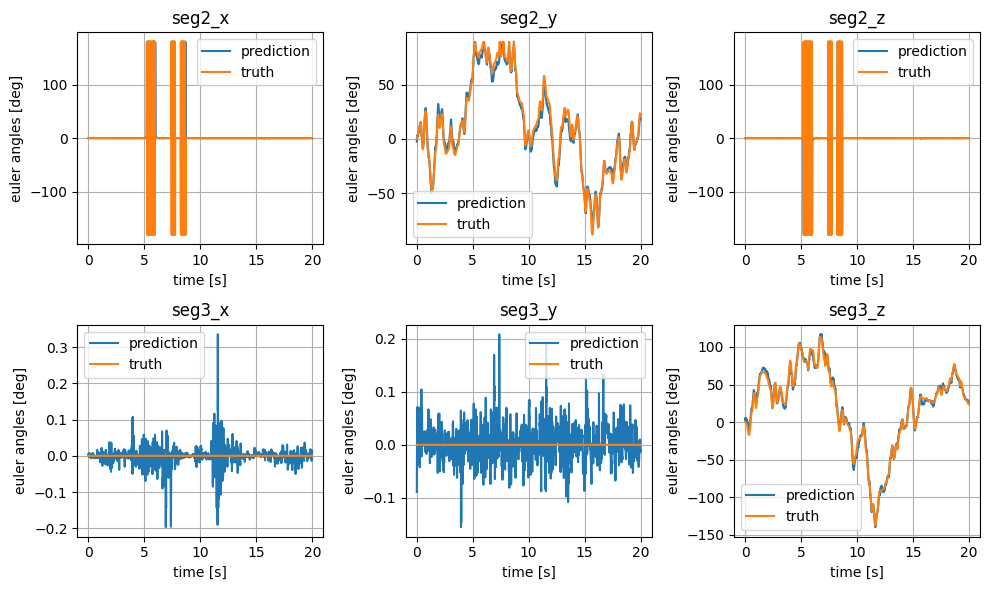

In [49]:
render = False # If you want to generate a video, visualizing the actual and inferred data, set this value to `True`.
video_path = "network_prediction.mp4"

pipeline.predict(
    sys=sys_inference,
    rnno_fn=rnno_v2,
    X=X,
    y=y,
    xs=xs,
    sys_xs=sys_rigid,
    params=params,
    plot=True,
    render=render,
    render_prediction=render,
    render_path=video_path,
    verbose=False
)

if (render):
    print(f"A video has been generated: {video_path}")